In [3]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import seaborn as sns
from matplotlib import colormaps
from result import *
from adjustText import adjust_text

def load_pkl(path):
    with open(path, 'rb') as file:
        loaded_dict = pickle.load(file)
    return loaded_dict

FILTERING_S_ALG = ['S_LONGEST', 'S_EARLIEST', 'S_RANDOM']
FILTERING_C_ALG = ['C_EARLIEST', 'C_RANDOM']
FILTERING_UE_ALG = ['UE_LONGEST', 'UE_RANDOM']
FILTERING_ACCESS_OPPORTUNITIES_ALG = ['4', '8', '12']
FILTER_MAX_AND_MIN = True
FILTER_PERCENT = 1


directory_path = './'
result = {}

# Loop through the files in the directory
for filename in os.listdir(directory_path):
    # Check if the file ends with .pkl
    if filename.endswith('.pkl'):
        source_alg = filename[:-4].split('|')[0]
        candidate_alg = filename[:-4].split('|')[1]
        ue_alg = filename[:-4].split('|')[2]
        access_opportunities = filename[:-4].split('|')[3]
        if (source_alg in FILTERING_S_ALG
        and candidate_alg in FILTERING_C_ALG
        and ue_alg in FILTERING_UE_ALG
        and access_opportunities in FILTERING_ACCESS_OPPORTUNITIES_ALG):
            result[(source_alg, candidate_alg, ue_alg, access_opportunities)] = load_pkl(filename)
            result[(source_alg, candidate_alg, ue_alg, access_opportunities)]['time_sat_matrix'] = np.array(result[(source_alg, candidate_alg, ue_alg, access_opportunities)]['time_sat_matrix'])

result = prepare_result(result, FILTER_MAX_AND_MIN, FILTER_PERCENT)

Those with small max signalling
Those with large max signalling


[(10, ('S_LONGEST', 'C_RANDOM', 'UE_LONGEST', '8')), (10, ('S_LONGEST', 'C_RANDOM', 'UE_LONGEST', '12'))]


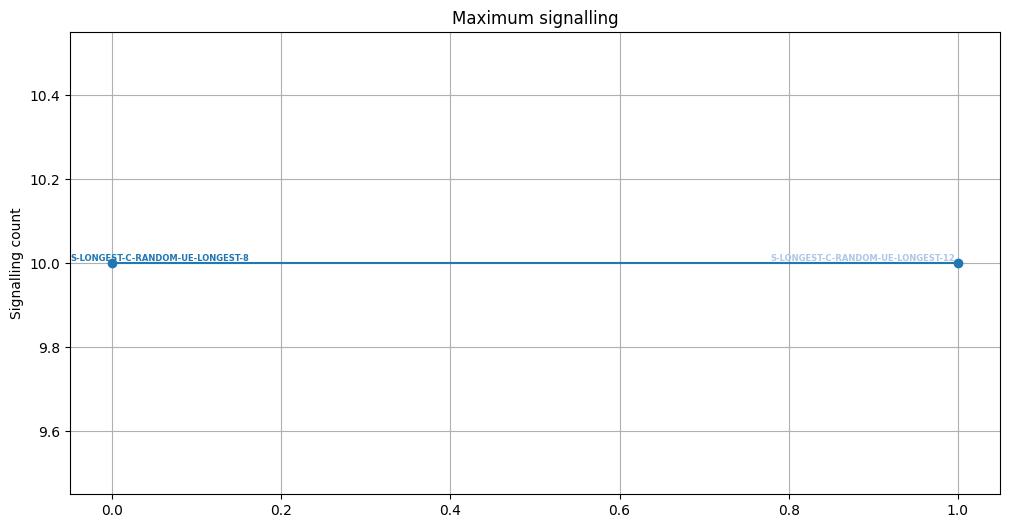

The total signalling: the lower, the better


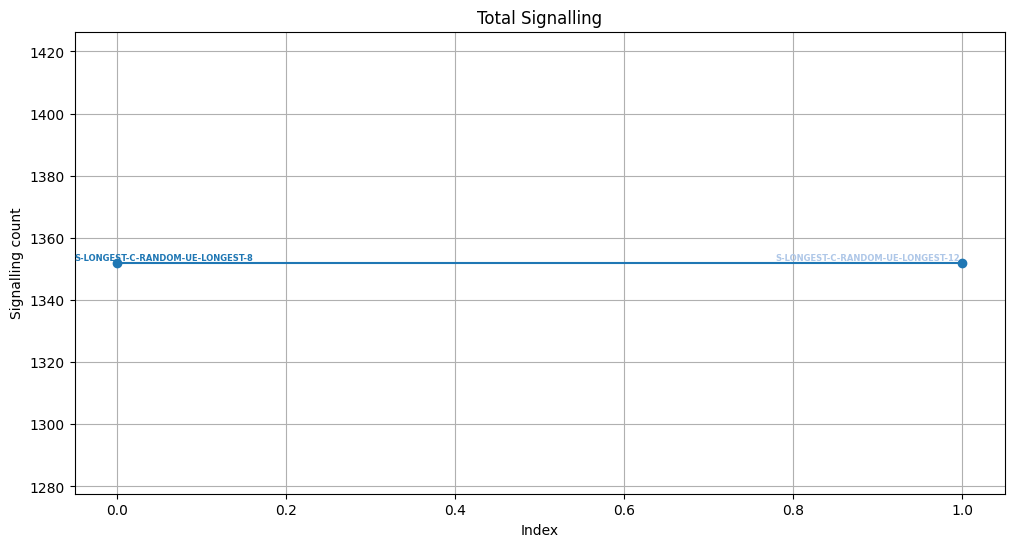

busy time slot shares: the lower, the better


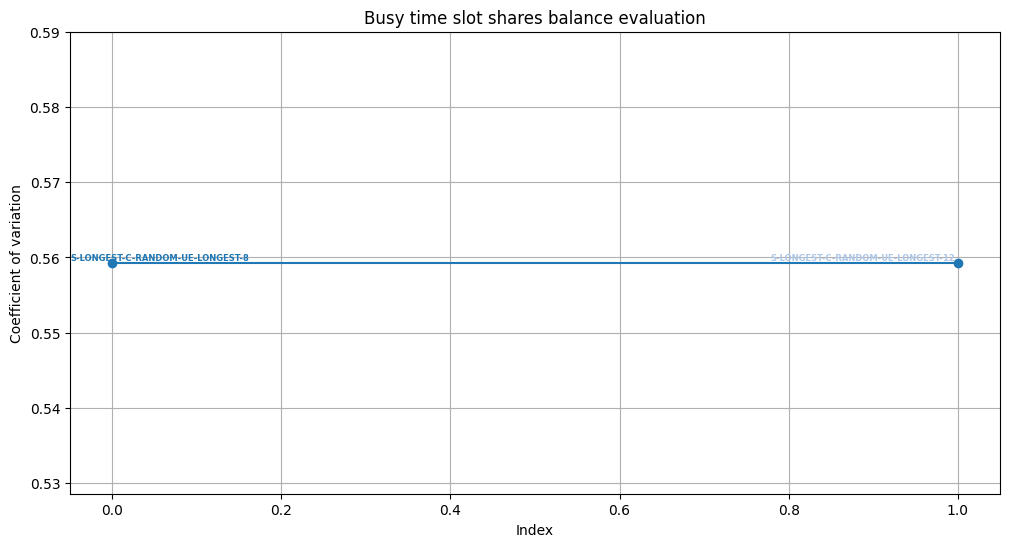

busy time slot signalling count confidence interval: the lower, the better
Total reservation time: the lower, the better


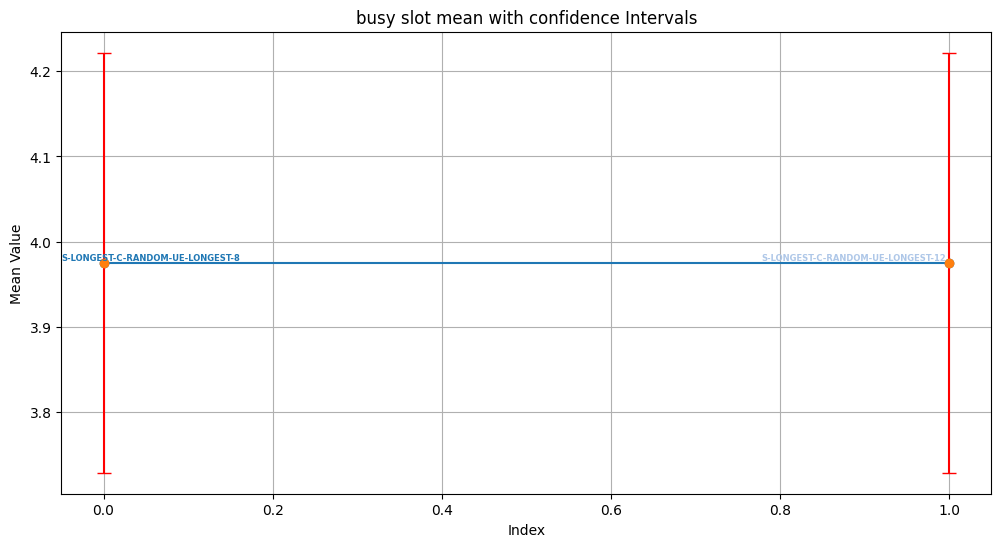

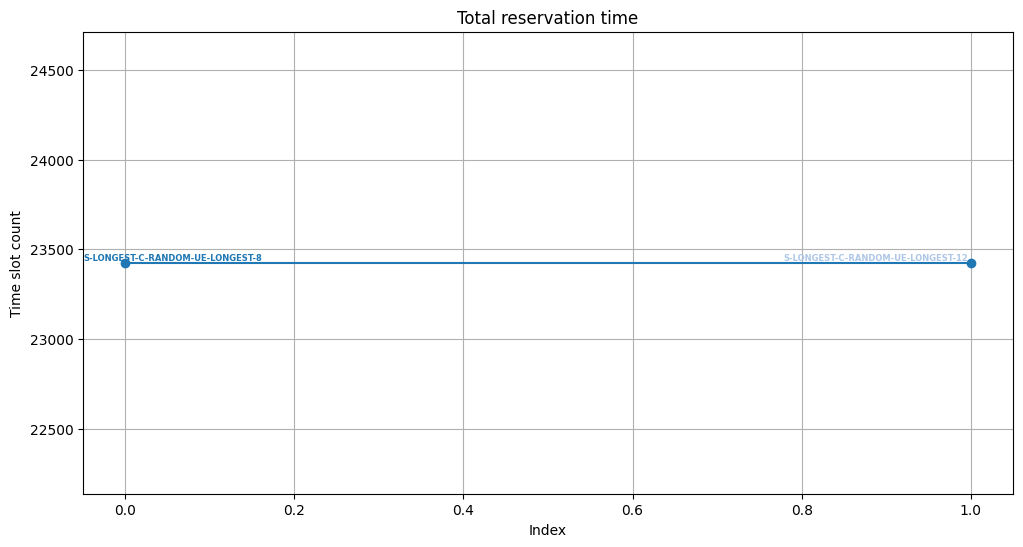

Reservation time balance: the lower the better


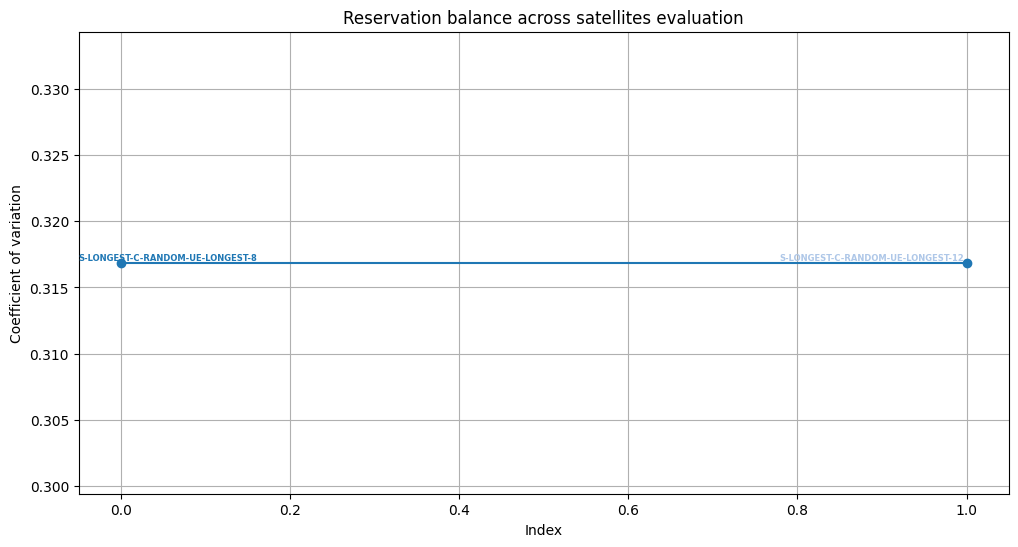

UE average access time: the lower, the better


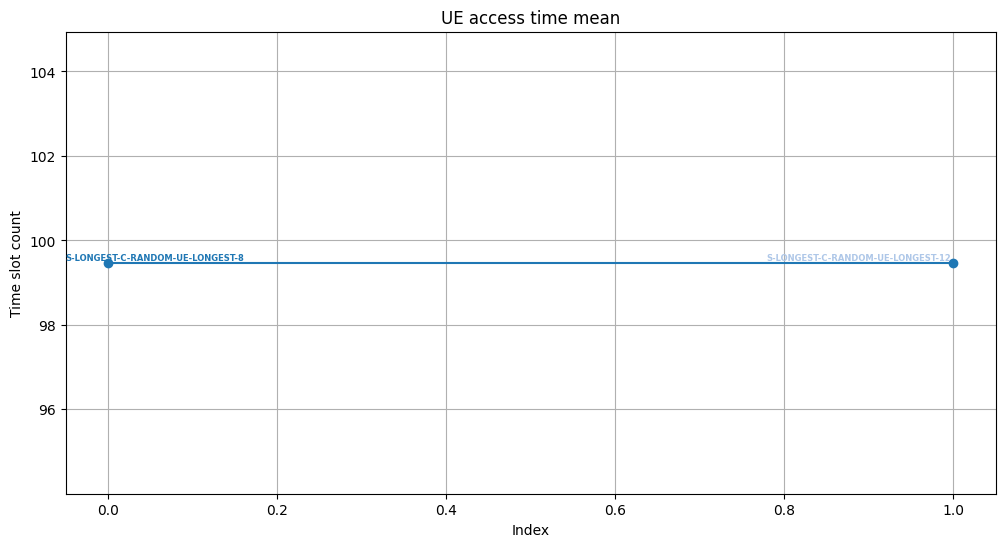

UE access time balance: the lower, the better


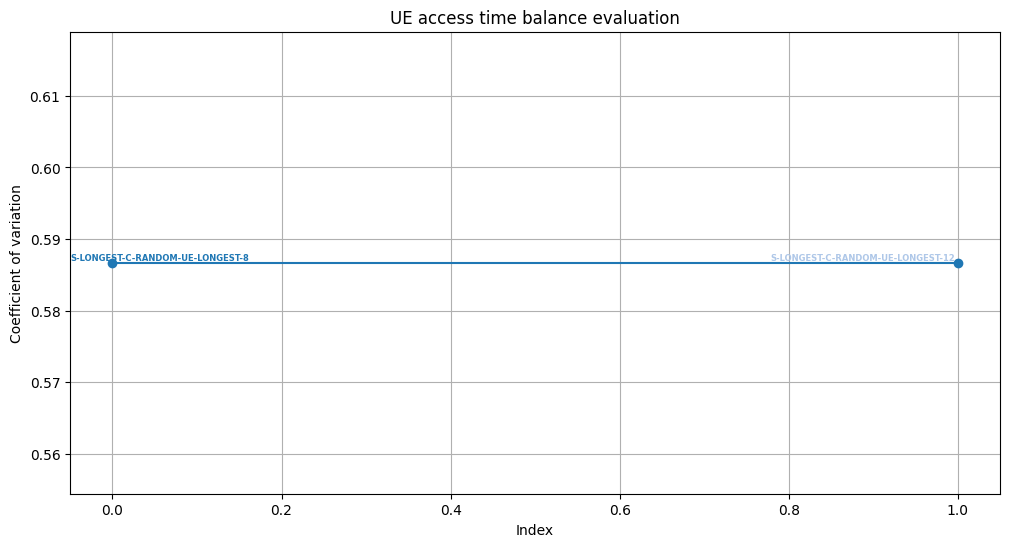

In [2]:
draw_prepared_result(result)

In [ ]:
# # The figure describes the maximum signalling of each satellite
# draw_max_signalling(result)
# draw_cumulative_load_each_time(result)
# draw_total_load_each_satellite(result)
# draw_busy_hour_distribution(result)
# draw_max_reservation(result)
# draw_heatmap(result, 100)